In [1]:
import h5py
from netCDF4 import Dataset
import numpy as np
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, sys
import xarray as xr
from scipy import interpolate

In [ ]:
sys.path.insert(1, '/home/sbidadi/atom/sbidadi')
from windtools.windtools.amrwind.post_processing  import Sampling

In [ ]:
from windtools.windtools.plotting import plot_timeheight, plot_timehistory_at_height, plot_profile, plot_spectrum
from windtools.windtools.amrwind.post_processing  import ABLStatistics, Sampling, addDatetime

sys.path.append(os.path.abspath('/home/rthedin/repos/mmctools'))
from mmctools.helper_functions import covariance, calc_wind, calc_spectra, fit_powerlaw

sys.path.append(os.path.abspath('/home/rthedin/utilities/'))
from helper import *

In [ ]:
ablstatdir = '/scratch/orybchuk/share/windai/simulations/offshore_batch/wspd5_wl25/production'
ablstat1 = os.path.join(ablstatdir,'post_processing','abl_statistics79020.nc') 

In [ ]:
abl1 = ABLStatistics(ablstat1, mean_profiles=True)
df1 = abl1.ds.to_dataframe()
calc_QOIs(df1,code='amr')
ds1 = df1.to_xarray()
ds1abl = ds1.copy()

In [ ]:
height = ds1abl.height

In [ ]:
theta = ds1abl['theta']

In [ ]:
theta

In [ ]:
theta_mean = np.mean(theta, axis=0)

In [ ]:
plt.figure()
plt.grid()
plt.plot(theta_mean,height)

# Create a boundary condition file

In [2]:
### User inputs
parent_dir = Path('/projects/ai4wind/sbidadi/generated_data')
data_file = Path(parent_dir, 'wspd5-sample00.nc')
#outfile = Path('/scratch/sbidadi/ai4wind/windai/simulations/maine_sweep/wspd05_ai', 'wspd5-sample00_out.nc')
outfile = Path('/scratch/sbidadi/ai4wind/windai/simulations/maine_sweep/wspd05_ai', 'amrwind_wspd_5_0_ai_inflow_bc.nc')

In [3]:
with Dataset(data_file, "r") as input:
    print("input.cmptypes", input.cmptypes)
    print("input.data_model", input.data_model)
    print("input.dimensions", input.dimensions)
    print("input.disk_format", input.disk_format)
    print("input.enumtypes", input.enumtypes)
    print("input.file_format", input.file_format)
    print("input.groups", input.groups)
    print("input.keepweakref", input.keepweakref)
    print("input.name", input.name)
    print("input.parent", input.parent)
    print("input.path", input.path)
    print("input.variables", input.variables)
    print("input.vltypes", input.vltypes)
    time_size = input['time'].size

input.cmptypes {}
input.data_model NETCDF4
input.dimensions {'sdim': <class 'netCDF4._netCDF4.Dimension'>: name = 'sdim', size = 1, 'pdim': <class 'netCDF4._netCDF4.Dimension'>: name = 'pdim', size = 2, 'vdim': <class 'netCDF4._netCDF4.Dimension'>: name = 'vdim', size = 3, 'nt': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'nt', size = 601}
input.disk_format HDF5
input.enumtypes {}
input.file_format NETCDF4
input.groups {'xlo': <class 'netCDF4._netCDF4.Group'>
group /xlo:
    dimensions(sizes): 
    variables(dimensions): int32 normal(), int32 side(), int32 perpendicular(pdim)
    groups: level_0}
input.keepweakref False
input.name /
input.parent None
input.path /
input.variables {'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(nt)
unlimited dimensions: nt
current shape = (601,)
filling on, default _FillValue of 9.969209968386869e+36 used}
input.vltypes {}


In [4]:
########### Create laminar zone for the last 1 minute of simulation data ###########
Niter_lz = 598

In [5]:
with Dataset(data_file, "r") as input:
    print(input['xlo/level_0'].variables)
    print()
    print(input['xlo/level_0'].variables['lengths'][:])
    print(input['xlo/level_0'].variables['lo'][:])
    print(input['xlo/level_0'].variables['hi'][:])
    print(input['xlo/level_0'].variables['dx'][:])
    print(input['xlo/level_0'].variables['velocity'].shape)
    print(input['xlo/level_0'].variables['temperature'].shape)
#    print(input['xlo/level_0'].variables['vof'].shape)
    
    print(input['xlo']['normal'][:])
    print(input['xlo']['side'][:])
    print(input['xlo']['perpendicular'][:])

    # read all the variables:
    time_bc = input['time'][:]
    ntime = input['time'].shape
    
    lengths0 = [640, 160] # input['xlo/level_0'].variables['lengths'][:]
    lo0 = input['xlo/level_0'].variables['lo'][:]
    hi0 = input['xlo/level_0'].variables['hi'][:]
    grid_size0 = input['xlo/level_0'].variables['dx'][:]
    
    # read the velocity and temperature:
    xlo0_xvelocity_input = input['xlo/level_0'].variables['velocity'][-Niter_lz:,:,:,0].astype(np.float32)
    xlo0_yvelocity_input = input['xlo/level_0'].variables['velocity'][-Niter_lz:,:,:,1].astype(np.float32)
    xlo0_zvelocity_input = input['xlo/level_0'].variables['velocity'][-Niter_lz:,:,:,2].astype(np.float32)
    xlo0_temperature_input = input['xlo/level_0'].variables['temperature'][-Niter_lz:,:,:].astype(np.float32)

    # Assign scalar values for each time step
    for i in range(Niter_lz):
        xlo0_temperature_input[i,:,:] = 263.95  # Assign scalar (e.g., t+1) to all elements at time 

    print("hello")
    print(input['xlo']['normal'][:])
    print(input['xlo']['side'][:])
    print(input['xlo']['perpendicular'][:])
    print(lengths0)
    print(lo0)
    print(hi0)
    print(grid_size0)
    print(xlo0_xvelocity_input.shape)
    
    ny0 = xlo0_xvelocity_input.shape[1]
    nz0 = xlo0_xvelocity_input.shape[2]
    print(ny0, nz0)

{'lengths': <class 'netCDF4._netCDF4.Variable'>
float64 lengths(pdim)
path = /xlo/level_0
unlimited dimensions: 
current shape = (2,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lo': <class 'netCDF4._netCDF4.Variable'>
float64 lo(pdim)
path = /xlo/level_0
unlimited dimensions: 
current shape = (2,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'hi': <class 'netCDF4._netCDF4.Variable'>
float64 hi(pdim)
path = /xlo/level_0
unlimited dimensions: 
current shape = (2,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'dx': <class 'netCDF4._netCDF4.Variable'>
float64 dx(pdim)
path = /xlo/level_0
unlimited dimensions: 
current shape = (2,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'velocity': <class 'netCDF4._netCDF4.Variable'>
float64 velocity(nt, ny, nz, vdim)
path = /xlo/level_0
unlimited dimensions: nt
current shape = (601, 512, 128, 3)
filling on, default _FillValue of 9.969209968386869e+36 used, 'vof': <class 'netCDF4._

In [6]:
# Obtain the cell centers
y0 = np.linspace(lo0[0] + grid_size0[0]/2, hi0[0]-grid_size0[0]/2, ny0, endpoint=True)
z0 = np.linspace(lo0[1] + grid_size0[0]/2 + 80., hi0[1]-grid_size0[1]/2 + 80., nz0, endpoint=True)
print(z0)
Y0, Z0 = np.meshgrid(y0, z0, indexing='ij')

[  0.625   1.875   3.125   4.375   5.625   6.875   8.125   9.375  10.625
  11.875  13.125  14.375  15.625  16.875  18.125  19.375  20.625  21.875
  23.125  24.375  25.625  26.875  28.125  29.375  30.625  31.875  33.125
  34.375  35.625  36.875  38.125  39.375  40.625  41.875  43.125  44.375
  45.625  46.875  48.125  49.375  50.625  51.875  53.125  54.375  55.625
  56.875  58.125  59.375  60.625  61.875  63.125  64.375  65.625  66.875
  68.125  69.375  70.625  71.875  73.125  74.375  75.625  76.875  78.125
  79.375  80.625  81.875  83.125  84.375  85.625  86.875  88.125  89.375
  90.625  91.875  93.125  94.375  95.625  96.875  98.125  99.375 100.625
 101.875 103.125 104.375 105.625 106.875 108.125 109.375 110.625 111.875
 113.125 114.375 115.625 116.875 118.125 119.375 120.625 121.875 123.125
 124.375 125.625 126.875 128.125 129.375 130.625 131.875 133.125 134.375
 135.625 136.875 138.125 139.375 140.625 141.875 143.125 144.375 145.625
 146.875 148.125 149.375 150.625 151.875 153.125 15

In [7]:
# The length of the domain in the y and z direction
ylo, zlo = 0, 0.
yhi, zhi =  640., 160.

# New grid
ny = 128
nz = 32

dy, dz = (yhi-ylo)/ny, (zhi-zlo)/nz
print(dy, dz)

# The desired output at cell centers
y_out = np.linspace(ylo + dy/2, yhi-dy/2, ny, endpoint=True)
z_out = np.linspace(zlo + dz/2, zhi-dy/2, nz, endpoint=True)

Y, Z = np.meshgrid(y_out, z_out, indexing='ij')
print(z_out)
print(Y.shape)

5.0 5.0
[  2.5   7.5  12.5  17.5  22.5  27.5  32.5  37.5  42.5  47.5  52.5  57.5
  62.5  67.5  72.5  77.5  82.5  87.5  92.5  97.5 102.5 107.5 112.5 117.5
 122.5 127.5 132.5 137.5 142.5 147.5 152.5 157.5]
(128, 32)


In [8]:
# Copy information from old to new (coarser) grid
# Create arrays with proper dimensions and populate data with arrays
velocity_bc = np.zeros((Niter_lz, ny, nz, 3),dtype='f')
temperature_bc = np.zeros((Niter_lz, ny, nz),dtype='f')

for nt in range(Niter_lz):
    # # Build a 2D interpolator from PINACLES data
    u_int = interpolate.RegularGridInterpolator((y0, z0), xlo0_xvelocity_input[nt, :, :], method='nearest', bounds_error=False, fill_value=None)
    v_int = interpolate.RegularGridInterpolator((y0, z0), xlo0_yvelocity_input[nt, :, :], method='nearest', bounds_error=False, fill_value=None)
    w_int = interpolate.RegularGridInterpolator((y0, z0), xlo0_zvelocity_input[nt, :, :], method='nearest', bounds_error=False, fill_value=None)
#    T_int = interpolate.RegularGridInterpolator((y, z), T_data[nt, 0, :,:], method='linear', bounds_error=False, fill_value=None)

    # Interpolate the data 
    velocity_bc[nt, :, :, 0] = u_int((Y, Z))
    velocity_bc[nt, :, :, 1] = v_int((Y, Z))
    velocity_bc[nt, :, :, 2] = w_int((Y, Z))
#    temperature_bc[nt, :, :] = T_int((Y, Z))

# Assign scalar values for each time step
for i in range(Niter_lz):
    temperature_bc[i, :, :] = 263.95  # Assign scalar (e.g., t+1) to all elements at time 

In [ ]:
# # outfile = Path(template_file.parent, synthetic_bcs.nc)
# with Dataset(outfile, "w", format="NETCDF4") as rootgrp:
#     ## ~~~~~~~~ Operate on the root group ~~~~~~~~
#     # Add dimensions to the root group
#     rootgrp.createDimension('sdim', 1)
#     rootgrp.createDimension('pdim', 2)
#     rootgrp.createDimension('vdim', 3)
#     rootgrp.createDimension('nt', None)
    
#     # Add groups
#     grp_xlo = rootgrp.createGroup("/xlo")
    
#     # Add variables    
#     rootgrp.createVariable("time","f8",("nt",))
#     rootgrp['time'][:] = time_bc #times_in_seconds

#     ## ~~~~~~~~ Operate on the xlo and ylo groups ~~~~~~~~
#     # No need to add dimensions

#     # Add variables
#     grp_xlo.createVariable("normal","i4",)
#     grp_xlo.createVariable("side","i4",)
#     grp_xlo.createVariable("perpendicular","i4",("pdim",))
    
#     grp_xlo['normal'][:] = 0
#     grp_xlo['side'][:] = 0
#     grp_xlo['perpendicular'][:] = [1, 2]

#     ## ~~~~~~~~ Operate on the xlo/level_0 and ylo/level_0 groups ~~~~~~~~
#     # Add groups
#     grp_xlo_l0 = grp_xlo.createGroup('/level_0')

#     # Add dimensions
#     grp_xlo_l0.createDimension('nx', 1)
#     grp_xlo_l0.createDimension('ny', ny)
#     grp_xlo_l0.createDimension('nz', nz)

#     # Add variables
#     grp_xlo_l0.createVariable("lengths","f8",("pdim",))
#     grp_xlo_l0.createVariable("lo","f8",("pdim",))
#     grp_xlo_l0.createVariable("hi","f8",("pdim",))
#     grp_xlo_l0.createVariable("dx","f8",("pdim",))
#     grp_xlo_l0.createVariable("velocity","f8",("nt", "ny", "nz", "vdim",))
#     grp_xlo_l0.createVariable("temperature","f8",("nt", "ny", "nz",))
# #    grp_xlo_l0.createVariable("vof","f8",("nt", "ny", "nz",))
    
#     grp_xlo_l0['lengths'][:] = [lengths0[0], lengths0[1]]
#     grp_xlo_l0['lo'][:] = [ylo, zlo]
#     grp_xlo_l0['hi'][:] = [yhi, zhi]
#     grp_xlo_l0['dx'][:] = [dy, dz]
#     grp_xlo_l0['velocity'][:] = velocity0_bc
#     grp_xlo_l0['temperature'][:] = temperature0_bc
# #    grp_xlo_l0['vof'][:] = vof_bc_new
    
#     print("hello")
#     print(1, ny, nz)
#     print(grp_xlo_l0['lengths'][:])
#     print(grp_xlo_l0['velocity'])
#     print(grp_xlo_l0['lo'][:])
#     print(grp_xlo_l0['hi'][:])
#     print(grp_xlo_l0['dx'][:])
#     print(velocity0_bc.shape)

In [ ]:
# mpl.rcParams['axes.titlesize'] = 26
# mpl.rcParams['axes.labelsize'] = 26
# mpl.rcParams['legend.fontsize'] = 26
# mpl.rcParams['xtick.labelsize'] = 26
# mpl.rcParams['ytick.labelsize'] = 26

# fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(20,20))
# #yy_new = np.arange(ylo0, yhi0, dy0)
# #zz_new = np.arange(zlo0, zhi0, dz0)
# #YY_new, ZZ_new = np.meshgrid(yy_new, zz_new, indexing='ij')
# wvel_new0 = axs[0,0].pcolormesh(Y0, Z0, xlo0_xvelocity_input[1,:,:])
# wvel_new1 = axs[0,1].pcolormesh(Y, Z, velocity0_bc[1,:,:,0])
# axs[0,0].set_xlabel("y")
# axs[0,0].set_ylabel("z")
# axs[0,0].set_title("w velocity - new domain")

# axs[0,1].set_xlabel("y")
# axs[0,1].set_ylabel("z")
# axs[0,1].set_title("w velocity - new domain")
# fig.colorbar(wvel_new0, ax=axs[0,0])

# fig.colorbar(wvel_new1, ax=axs[0,1])

In [ ]:
# ilengths0 = lengths0

# ncells0 = xlo0_xvelocity_input.shape

# nx0 = 1
# ny0 = ncells0[1]
# nz0 = ncells0[2]

# Ly0 = ilengths0[0]
# Lz0 = ilengths0[1]
# print(Ly0, Lz0)

# dy0 = grid_size0[0]
# dz0 = grid_size0[1]

# Level 0

## Old domain

In [9]:
# copy information of the new grid to new variables
velocity0_bc = np.zeros((Niter_lz, ny, nz, 3),dtype='f')
temperature0_bc = np.zeros((Niter_lz, ny, nz),dtype='f')
velocity0_bc[:,:,:,0] = velocity_bc[:, :, :, 0]
velocity0_bc[:,:,:,1] = velocity_bc[:, :, :, 1]
velocity0_bc[:,:,:,2] = velocity_bc[:, :, :, 2]
temperature0_bc[:,:,:] = temperature_bc

In [10]:
print(lengths0)

[640, 160]


In [11]:
# #ilengths0 = lengths0.astype(int) # domain size in the y and z dir.
# ilengths0 = [640, 160]

# ncells0 = xlo0_xvelocity_input.shape

# nx0 = 1
# ny0 = ncells0[1]
# nz0 = ncells0[2]

# Ly0 = ilengths0[0]
# Lz0 = ilengths0[1]
# print(Ly0, Lz0)

# dy0 = grid_size0[0]
# dz0 = grid_size0[1]

# x0_velocity_bc = xlo0_xvelocity_input.copy()
# y0_velocity_bc = xlo0_yvelocity_input.copy()
# z0_velocity_bc = xlo0_zvelocity_input.copy()
# temperature0_bc = xlo0_zvelocity_input.copy()

# # Assign scalar values for each time step
# for i in range(Niter_lz):
#     temperature0_bc[i, :, :] = 263.95  # Assign scalar (e.g., t+1) to all elements at time 
    
# print(x0_velocity_bc.shape)

In [12]:
# mean velocity vs. z
x0_velocity_bc = velocity0_bc[:-2,:,:,0].copy()
y0_velocity_bc = velocity0_bc[:-2,:,:,1].copy()
z0_velocity_bc = velocity0_bc[:-2,:,:,2].copy()
temperature0_bc = temperature0_bc[:-2,:,:].copy()

uvel0_mean = np.mean(x0_velocity_bc,axis=(0,1)) # mean in both y dir. and time
vvel0_mean  = np.mean(y0_velocity_bc,axis=(0,1)) # mean in both y dir. and time
wvel0_mean  = np.mean(z0_velocity_bc,axis=(0,1)) # mean in both y dir. and time
temperature0_mean  = np.mean(temperature0_bc,axis=(0,1)) # mean in both y dir. and time

print(temperature0_bc.shape)
print(x0_velocity_bc.shape)

(596, 128, 32)
(596, 128, 32)


# Padding the existing domain with a laminar zone

In [13]:
# Calculate the number of cells and domain size
# Additional increment in the domain:
#delta_Ly = 300
#delta_Lz = 120

Ly0 = lengths0[0]
Lz0 = lengths0[1]
print(Ly0, Lz0)
print("")

delta_Ly = 200 #1020
delta_Lz = 200 #1020

# New domain size
new_ilengths0 = [Ly0+delta_Ly, Lz0+delta_Lz]
Ly0_new = new_ilengths0[0]
Lz0_new = new_ilengths0[1]
print(Ly0_new, Lz0_new)
print("")

# Number of new cells
Ny0 = (np.rint(((yhi-ylo)+delta_Ly)/dy)).astype(int)
Nz0 = (np.rint(((zhi-zlo)+delta_Lz)/dz)).astype(int)
print(Ny0, Nz0)
print("")

# Extents of the new domain
# y direction:
ylo0 = ylo 
yhi0 = yhi + delta_Ly

# z direction:
zlo0 = zlo
zhi0 = zhi + delta_Lz
print("new domain extent")
print(ylo0, yhi0, zlo0, zhi0)

print(ntime)
#timesteps = (np.ceil(ntime[0]/10)).astype(int)
timesteps = ntime[0]
print(timesteps)

# Variables for storing velocity and temperature fields in the new domain
velocity0_bc_new = np.zeros((Niter_lz-2, Ny0, Nz0, 3),dtype='f')
temperature0_bc_new = np.full((Niter_lz-2, Ny0, Nz0),263.95)
print(np.max(temperature0_mean))

640 160

840 360

168 72

new domain extent
0 840.0 0.0 360.0
(601,)
601
263.99692


In [14]:
# region of the new domain where information from the old domain need to be copied:
start_y = int(delta_Ly/2)
start_z = int(delta_Lz/2)

end_y = start_y + Ly0
end_z = start_z + Lz0

print(start_y, end_y)
print(start_z, end_z)

# Fill data in the new domain for regions between yloc < start_y or yloc > end_y and zloc > start_z and zloc < end_z
# This is done by copying the variable profiles from the old domain data to the new

# Number of points from the left and bottom boundary to the location where filling begins:
Ny_from_left_boundary = int(start_y/dy) 
Nz_from_bottom_boundary = int(start_z/dz)  

uvelocity0_bc_new = np.zeros((Ny0, Nz0),dtype='f')
vvelocity0_bc_new = np.zeros((Ny0, Nz0),dtype='f')
wvelocity0_bc_new = np.zeros((Ny0, Nz0),dtype='f')
T0_bc_new = np.zeros((Ny0, Nz0),dtype='f')

for j in range(Ny0): # in the y dir
    for k in range(Nz0): # in the z dir
        yloc = j*dy
        zloc = k*dz

        if ((yloc < start_y or yloc > end_y) and (zloc > start_z and zloc < end_z)):
            uvelocity0_bc_new[:,k] = uvel0_mean[k-Nz_from_bottom_boundary]
            vvelocity0_bc_new[:,k] = vvel0_mean[k-Nz_from_bottom_boundary]
            wvelocity0_bc_new[:,k] = wvel0_mean[k-Nz_from_bottom_boundary]
            T0_bc_new[:,k] = 263.95 #temperature0_mean[k-Nz_from_bottom_boundary]

velocity0_bc_new[:,:,:,0] = uvelocity0_bc_new[:,:]
velocity0_bc_new[:,:,:,1] = vvelocity0_bc_new[:,:]
velocity0_bc_new[:,:,:,2] = wvelocity0_bc_new[:,:]
temperature0_bc_new[:,:,:] = T0_bc_new[:,:]

100 740
100 260


(596, 128, 32)


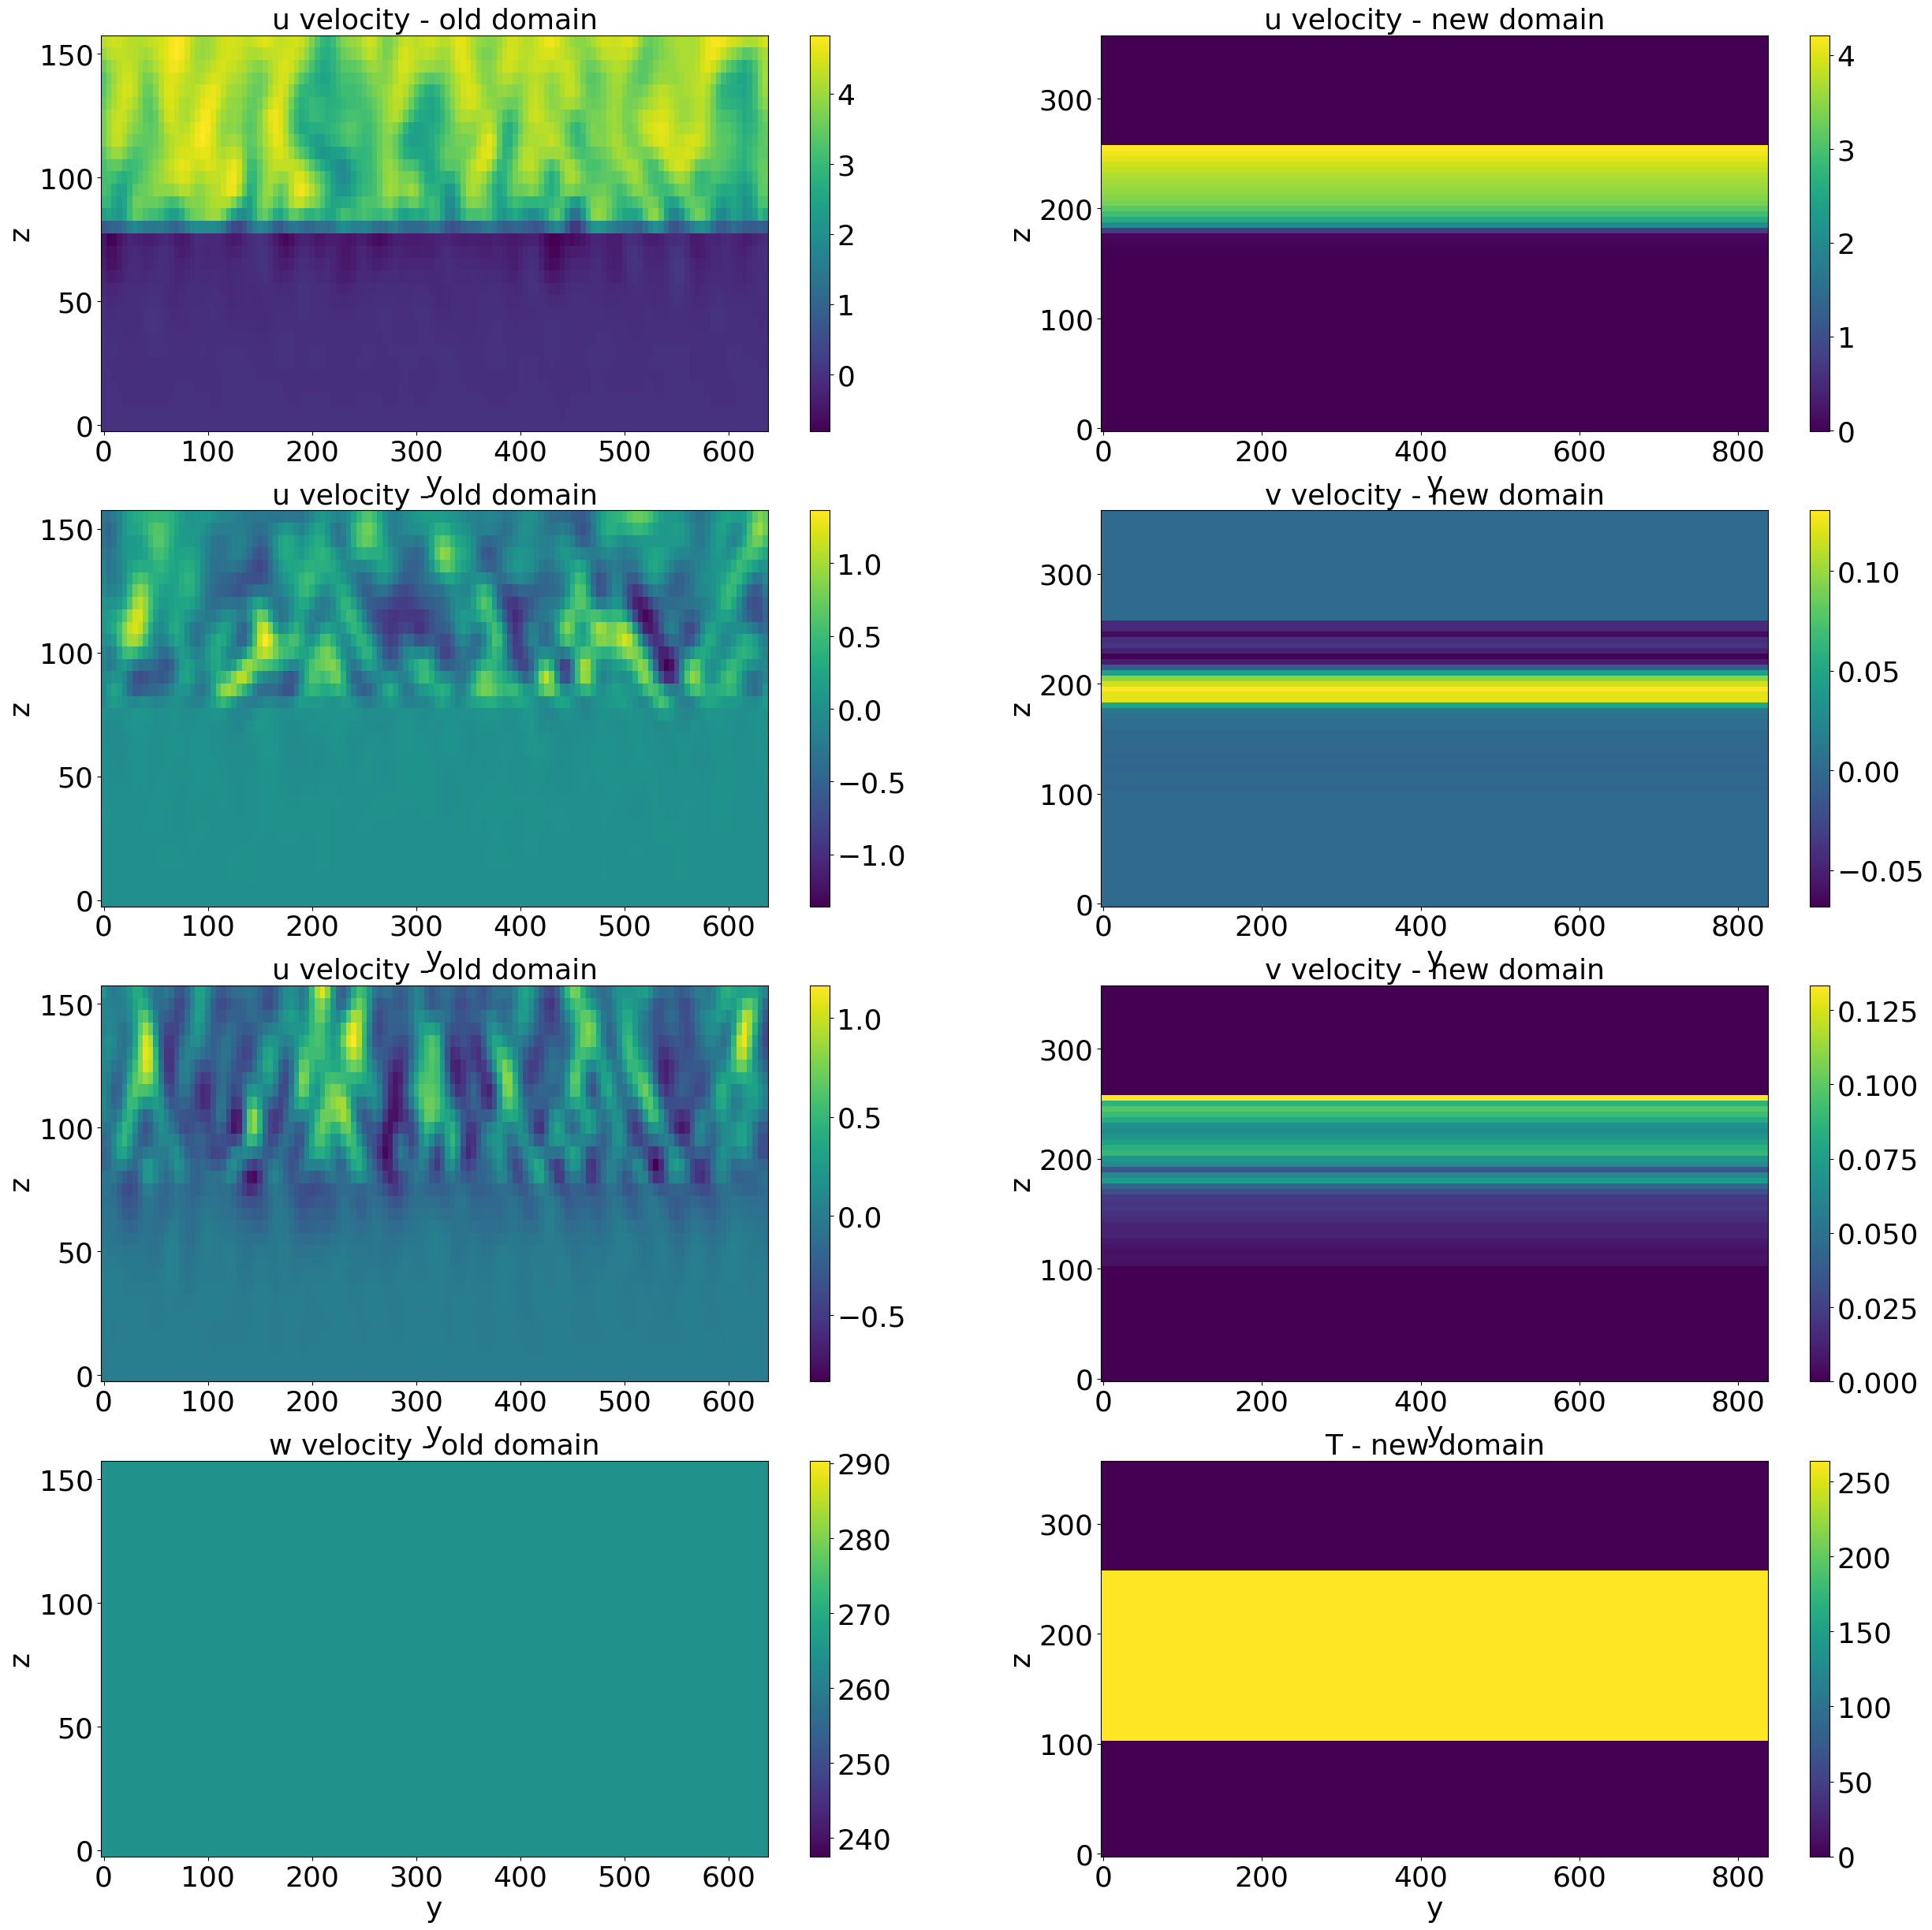

In [15]:
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['axes.labelsize'] = 26
mpl.rcParams['legend.fontsize'] = 26
mpl.rcParams['xtick.labelsize'] = 26
mpl.rcParams['ytick.labelsize'] = 26

print(x0_velocity_bc.shape)
fig, axs = plt.subplots(nrows=4,ncols=2,figsize=(30,30))

# 1. u velocity:
yy = np.arange(ylo, yhi, dy)
zz = np.arange(zlo, zhi, dz)
YY, ZZ = np.meshgrid(yy, zz, indexing='ij')
uvel = axs[0,0].pcolormesh(YY, ZZ, x0_velocity_bc[-1,:,:])
axs[0,0].set_xlabel("y")
axs[0,0].set_ylabel("z")
axs[0,0].set_title("u velocity - old domain")
fig.colorbar(uvel, ax=axs[0,0])

yy_new = np.arange(ylo0, yhi0, dy)
zz_new = np.arange(zlo0, zhi0, dz)
YY_new, ZZ_new = np.meshgrid(yy_new, zz_new, indexing='ij')
uvel_new = axs[0,1].pcolormesh(YY_new, ZZ_new, velocity0_bc_new[-1,:,:,0])
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].set_title("u velocity - new domain")
fig.colorbar(uvel_new, ax=axs[0,1])

yy = np.arange(ylo, yhi, dy)
zz = np.arange(zlo, zhi, dz)
YY, ZZ = np.meshgrid(yy, zz, indexing='ij')
uvel = axs[1,0].pcolormesh(YY, ZZ, y0_velocity_bc[-1,:,:])
axs[1,0].set_xlabel("y")
axs[1,0].set_ylabel("z")
axs[1,0].set_title("u velocity - old domain")
fig.colorbar(uvel, ax=axs[1,0])

yy_new = np.arange(ylo0, yhi0, dy)
zz_new = np.arange(zlo0, zhi0, dz)
YY_new, ZZ_new = np.meshgrid(yy_new, zz_new, indexing='ij')
uvel_new = axs[1,1].pcolormesh(YY_new, ZZ_new, velocity0_bc_new[-1,:,:,1])
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].set_title("v velocity - new domain")
fig.colorbar(uvel_new, ax=axs[1,1])

yy = np.arange(ylo, yhi, dy)
zz = np.arange(zlo, zhi, dz)
YY, ZZ = np.meshgrid(yy, zz, indexing='ij')
uvel = axs[2,0].pcolormesh(YY, ZZ, z0_velocity_bc[-1,:,:])
axs[2,0].set_xlabel("y")
axs[2,0].set_ylabel("z")
axs[2,0].set_title("u velocity - old domain")
fig.colorbar(uvel, ax=axs[2,0])

yy_new = np.arange(ylo0, yhi0, dy)
zz_new = np.arange(zlo0, zhi0, dz)
YY_new, ZZ_new = np.meshgrid(yy_new, zz_new, indexing='ij')
uvel_new = axs[2,1].pcolormesh(YY_new, ZZ_new, velocity0_bc_new[-1,:,:,2])
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].set_title("v velocity - new domain")
fig.colorbar(uvel_new, ax=axs[2,1])

yy = np.arange(ylo, yhi, dy)
zz = np.arange(zlo, zhi, dz)
YY, ZZ = np.meshgrid(yy, zz, indexing='ij')
uvel = axs[3,0].pcolormesh(YY, ZZ, temperature0_bc[-1,:,:])
axs[3,0].set_xlabel("y")
axs[3,0].set_ylabel("z")
axs[3,0].set_title("w velocity - old domain")
fig.colorbar(uvel, ax=axs[3,0])

yy_new = np.arange(ylo0, yhi0, dy)
zz_new = np.arange(zlo0, zhi0, dz)
YY_new, ZZ_new = np.meshgrid(yy_new, zz_new, indexing='ij')
uvel_new = axs[3,1].pcolormesh(YY_new, ZZ_new, temperature0_bc_new[-1,:,:])
axs[3,1].set_xlabel("y")
axs[3,1].set_ylabel("z")
axs[3,1].set_title("T - new domain")
fig.colorbar(uvel_new, ax=axs[3,1])

In [16]:
print(dz,start_z,end_z,Lz0_new)

5.0 100 260 360


In [17]:
# Polynomial extrapolation:
zlocs_start = np.arange(0.0, start_z, dz)
zlocs_end = np.arange(end_z, Lz0_new, dz)

# For u:
# Generate 2nd order polynomial function for data in the old domain
pstart_u = np.polyfit(zlocs_start, uvel0_mean[0:np.size(zlocs_start)], deg=2)
pend_u = np.polyfit(zlocs_end, uvel0_mean[-np.size(zlocs_end):], deg=2)

# Evaluate the polynomal at specific y values for z < start_z and z > end_z
uvel0_mean_new_start = np.polyval(pstart_u, zlocs_start)
uvel0_mean_new_end = np.polyval(pend_u, zlocs_end)

# Do the same for the other variables
# For v:
pstart_v = np.polyfit(zlocs_start, vvel0_mean[0:np.size(zlocs_start)], deg=2)
pend_v = np.polyfit(zlocs_end, vvel0_mean[-np.size(zlocs_end):], deg=2)

vvel0_mean_new_start = np.polyval(pstart_v, zlocs_start)
vvel0_mean_new_end = np.polyval(pend_v, zlocs_end)

# For w:
pstart_w = np.polyfit(zlocs_start, wvel0_mean[0:np.size(zlocs_start)], deg=2)
pend_w = np.polyfit(zlocs_end, wvel0_mean[-np.size(zlocs_end):], deg=2)

wvel0_mean_new_start = np.polyval(pstart_w, zlocs_start)
wvel0_mean_new_end = np.polyval(pend_w, zlocs_end)

# For T:
#pstart_T = np.polyfit(zlocs_start, temperature0_mean[0:np.size(zlocs_start)], deg=2)
#pend_T = np.polyfit(zlocs_end, temperature0_mean[-np.size(zlocs_end):], deg=2)

#T0_mean_new_start = np.polyval(pstart_T, zlocs_start)
#T0_mean_new_end = np.polyval(pend_T, zlocs_end)

# For VOF:
#pstart_vof = np.polyfit(zlocs_start, vof_mean[0:np.size(zlocs_start)], deg=2)
#pend_vof = np.polyfit(zlocs_end, vof_mean[-np.size(zlocs_end):], deg=2)

#vof_mean_new_start = np.polyval(pstart_vof, zlocs_start)
#vof_mean_new_end = np.polyval(pend_vof, zlocs_end)




In [18]:
print(uvel0_mean_new_end)

[0.35228622 0.59324228 0.83419833 1.07515438 1.31611044 1.55706649
 1.79802254 2.03897859 2.27993465 2.5208907  2.76184675 3.0028028
 3.24375886 3.48471491 3.72567096 3.96662701 4.20758307 4.44853912
 4.68949517 4.93045122]


In [19]:
# Copy the velocities evaluated for z < start_z and z > end_z at all y locations
for k in range(Nz0): # in the z dir
    zloc = k*dz

    if (zloc < start_z):
#        velocity0_bc_new[:, :, k, 0] = uvel0_mean_new_start[k]
#        velocity0_bc_new[:, :, k, 1] = vvel0_mean_new_start[k]
#        velocity0_bc_new[:, :, k, 2] = wvel0_mean_new_start[k]
        temperature0_bc_new[:, :, k] = 263.95 #T0_mean_new_start[k]
#        vof_bc_new[:, :, k] = vof_mean_new_start[k]      
    elif (zloc > end_z):
        velocity0_bc_new[:, :, k, 0] = uvel0_mean_new_end[Nz0-k]
        velocity0_bc_new[:, :, k, 1] = vvel0_mean_new_end[Nz0-k]
        velocity0_bc_new[:, :, k, 2] = wvel0_mean_new_end[Nz0-k]
        temperature0_bc_new[:, :, k] = 263.95 #T0_mean_new_end[Nz0-k]
#        vof_bc_new[:, :, k] = vof_mean_new_end[Nz-k]

index_loc = Nz0-np.size(zlocs_end)
velocity0_bc_new[:, :, index_loc, :] = velocity0_bc_new[:, :, index_loc+1, :]
temperature0_bc_new[:, :, index_loc] = 263.95 #temperature0_bc_new[:, :, index_loc+1]
temperature0_bc_new[:, :, np.size(zlocs_end)] = 263.95 #temperature0_bc_new[:, :, np.size(zlocs_end)+1]

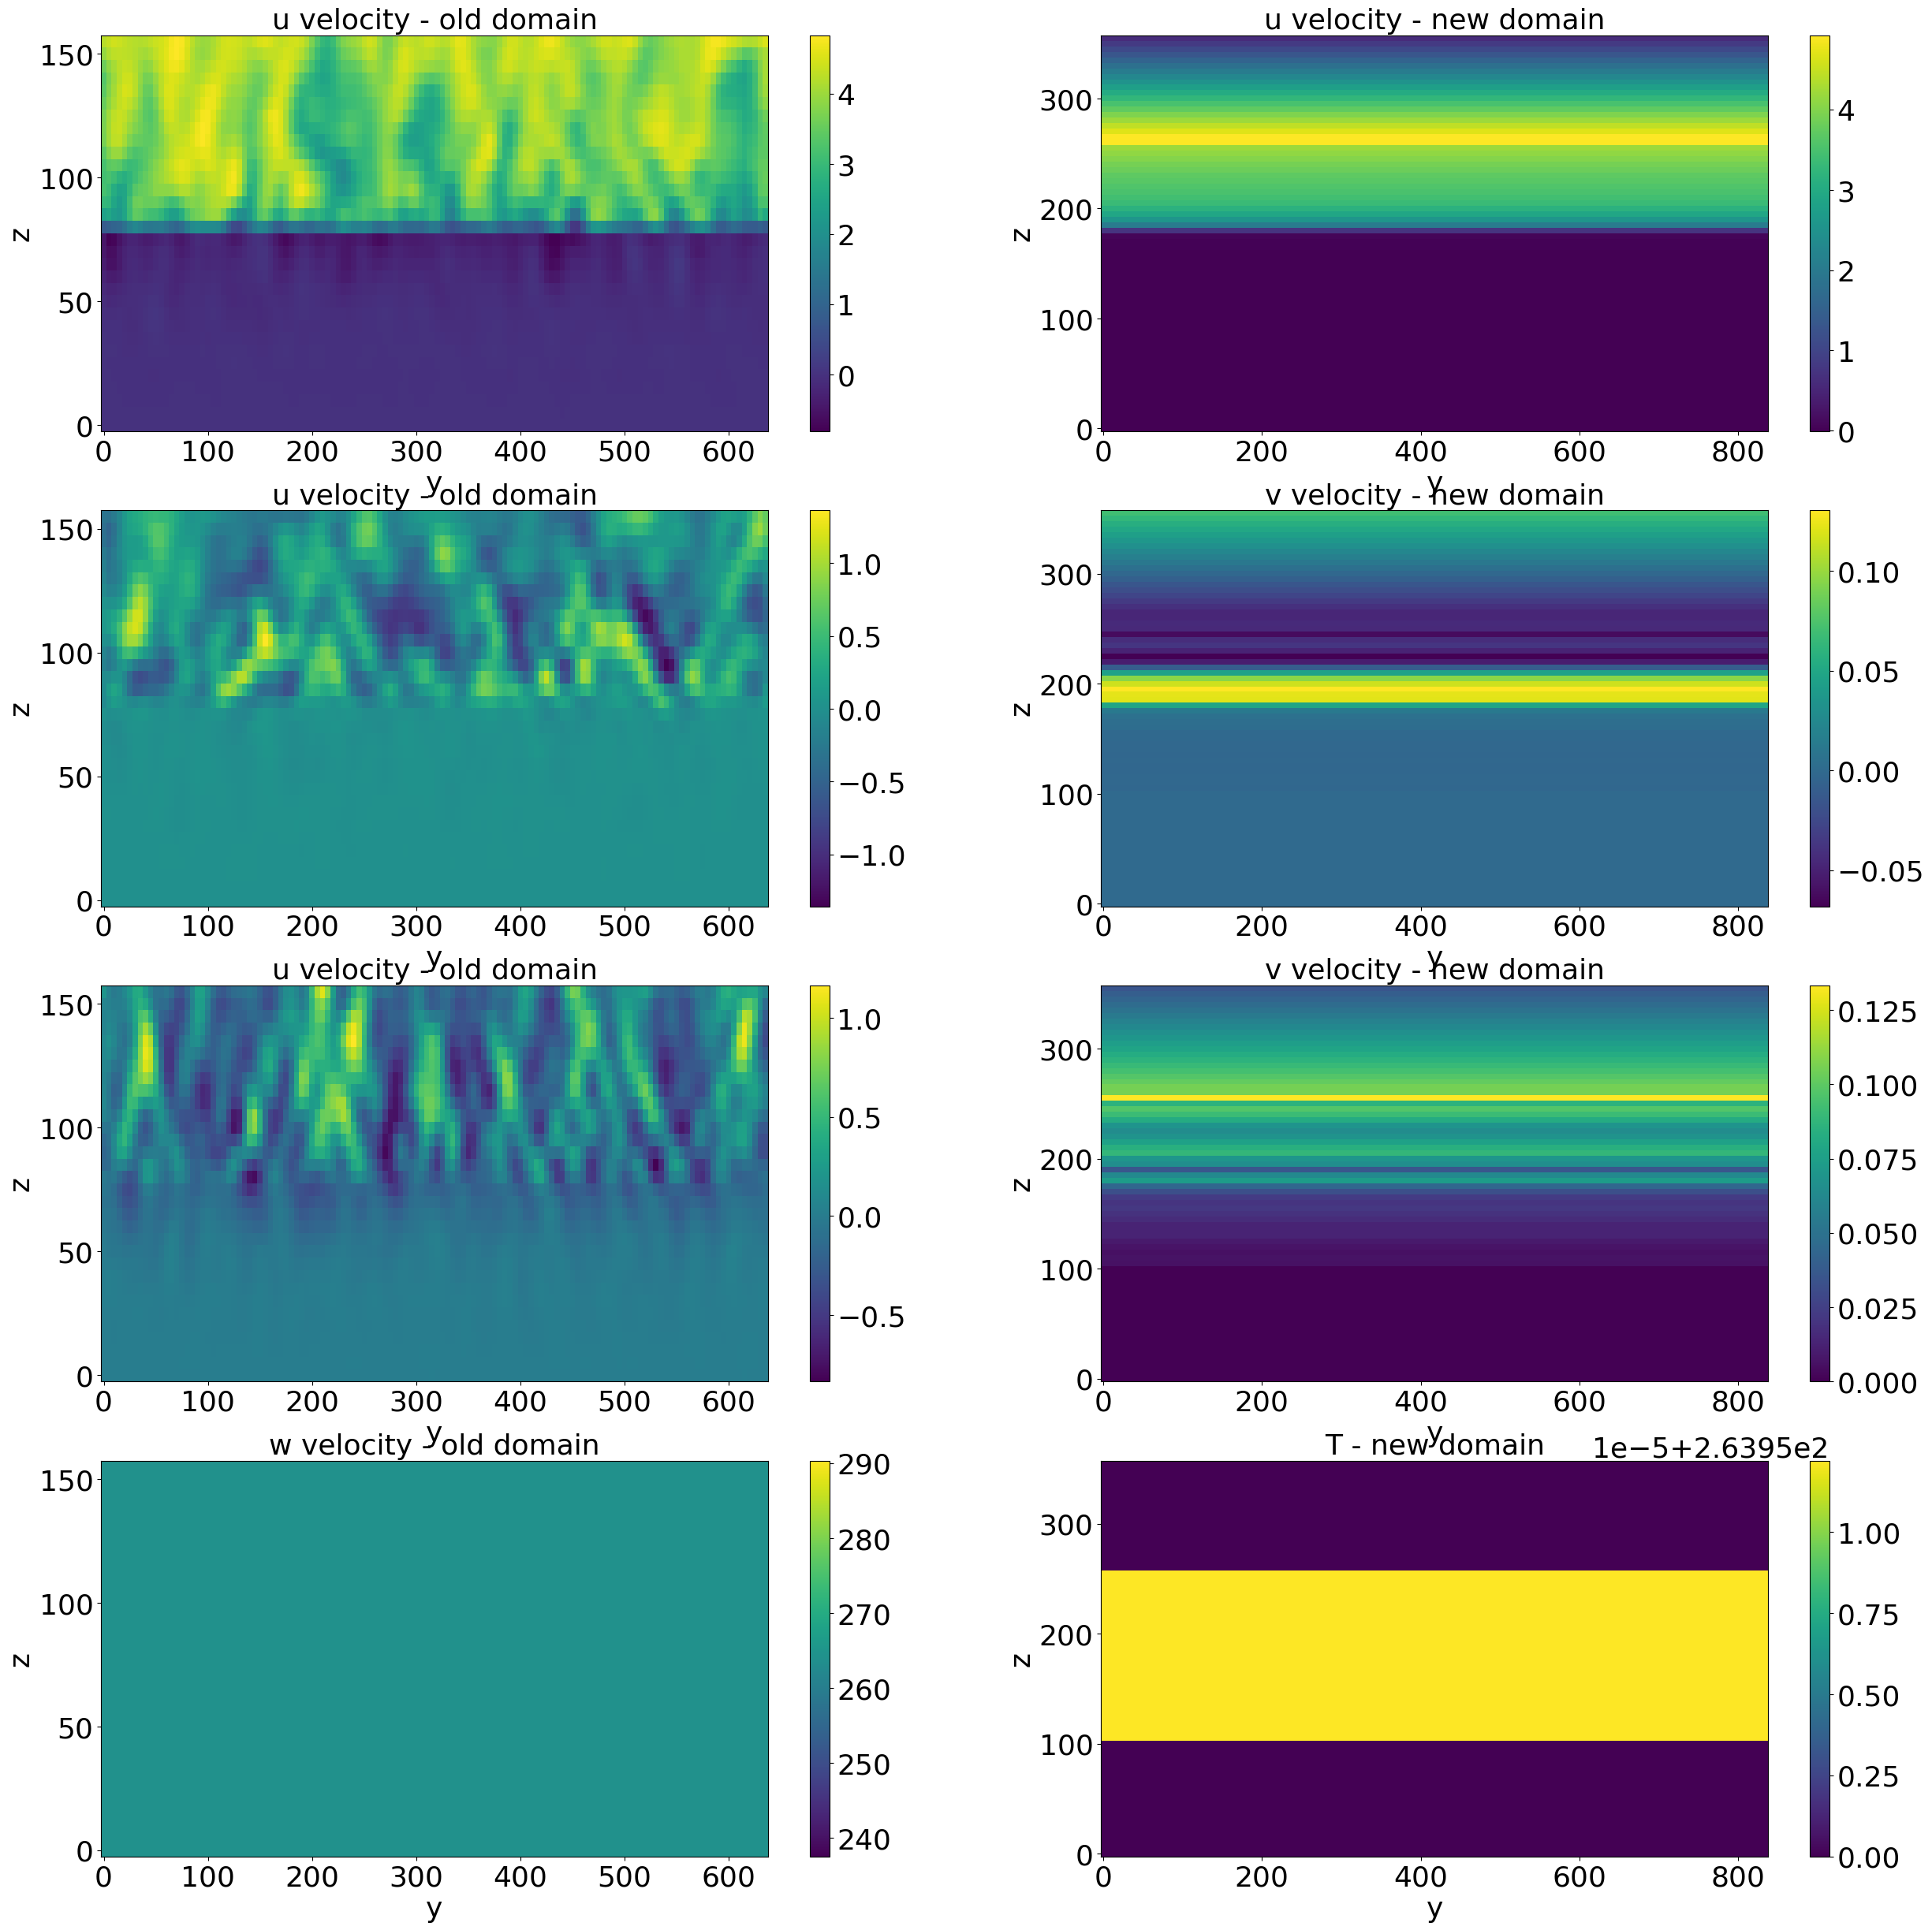

In [20]:
fig, axs = plt.subplots(nrows=4,ncols=2,figsize=(30,30))

# 1. u velocity:
yy = np.arange(ylo, yhi, dy)
zz = np.arange(zlo, zhi, dz)
YY, ZZ = np.meshgrid(yy, zz, indexing='ij')
uvel = axs[0,0].pcolormesh(YY, ZZ, x0_velocity_bc[-1,:,:])
axs[0,0].set_xlabel("y")
axs[0,0].set_ylabel("z")
axs[0,0].set_title("u velocity - old domain")
fig.colorbar(uvel, ax=axs[0,0])

yy_new = np.arange(ylo0, yhi0, dy)
zz_new = np.arange(zlo0, zhi0, dz)
YY_new, ZZ_new = np.meshgrid(yy_new, zz_new, indexing='ij')
uvel_new = axs[0,1].pcolormesh(YY_new, ZZ_new, velocity0_bc_new[-1,:,:,0])
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].set_title("u velocity - new domain")
fig.colorbar(uvel_new, ax=axs[0,1])

yy = np.arange(ylo, yhi, dy)
zz = np.arange(zlo, zhi, dz)
YY, ZZ = np.meshgrid(yy, zz, indexing='ij')
uvel = axs[1,0].pcolormesh(YY, ZZ, y0_velocity_bc[-1,:,:])
axs[1,0].set_xlabel("y")
axs[1,0].set_ylabel("z")
axs[1,0].set_title("u velocity - old domain")
fig.colorbar(uvel, ax=axs[1,0])

yy_new = np.arange(ylo0, yhi0, dy)
zz_new = np.arange(zlo0, zhi0, dz)
YY_new, ZZ_new = np.meshgrid(yy_new, zz_new, indexing='ij')
uvel_new = axs[1,1].pcolormesh(YY_new, ZZ_new, velocity0_bc_new[-1,:,:,1])
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].set_title("v velocity - new domain")
fig.colorbar(uvel_new, ax=axs[1,1])

yy = np.arange(ylo, yhi, dy)
zz = np.arange(zlo, zhi, dz)
YY, ZZ = np.meshgrid(yy, zz, indexing='ij')
uvel = axs[2,0].pcolormesh(YY, ZZ, z0_velocity_bc[-1,:,:])
axs[2,0].set_xlabel("y")
axs[2,0].set_ylabel("z")
axs[2,0].set_title("u velocity - old domain")
fig.colorbar(uvel, ax=axs[2,0])

yy_new = np.arange(ylo0, yhi0, dy)
zz_new = np.arange(zlo0, zhi0, dz)
YY_new, ZZ_new = np.meshgrid(yy_new, zz_new, indexing='ij')
uvel_new = axs[2,1].pcolormesh(YY_new, ZZ_new, velocity0_bc_new[-1,:,:,2])
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].set_title("v velocity - new domain")
fig.colorbar(uvel_new, ax=axs[2,1])

yy = np.arange(ylo, yhi, dy)
zz = np.arange(zlo, zhi, dz)
YY, ZZ = np.meshgrid(yy, zz, indexing='ij')
uvel = axs[3,0].pcolormesh(YY, ZZ, temperature0_bc[-1,:,:])
axs[3,0].set_xlabel("y")
axs[3,0].set_ylabel("z")
axs[3,0].set_title("w velocity - old domain")
fig.colorbar(uvel, ax=axs[3,0])

yy_new = np.arange(ylo0, yhi0, dy)
zz_new = np.arange(zlo0, zhi0, dz)
YY_new, ZZ_new = np.meshgrid(yy_new, zz_new, indexing='ij')
uvel_new = axs[3,1].pcolormesh(YY_new, ZZ_new, temperature0_bc_new[-1,:,:])
axs[3,1].set_xlabel("y")
axs[3,1].set_ylabel("z")
axs[3,1].set_title("T - new domain")
fig.colorbar(uvel_new, ax=axs[3,1])

In [21]:
print(velocity0_bc_new.shape)
print(delta_Ly, delta_Lz)

(596, 168, 72, 3)
200 200


In [22]:
# Region in the interior of the new domain where old data needs to be filled:
start_y = int(delta_Ly/2)
start_z = int(delta_Lz/2)

end_y = start_y + Ly0
end_z = start_z + Lz0

# Number of points from the left and bottom boundaries to the location where filling begins:
Ny_from_left_boundary = int(start_y/dy) + 1
Nz_from_bottom_boundary = int(start_z/dz) + 1  

#Ny_from_left_boundary = (start_y/grid_size0[0]).astype(int) + 1
#Nz_from_bottom_boundary = (start_z/grid_size0[1]).astype(int) + 1

print(Ny0, Nz0)
print(Ny_from_left_boundary, Nz_from_bottom_boundary)

for j in range(Ny0): # in the y dir
    for k in range(Nz0): # in the z dir
        yloc = j*dy
        zloc = k*dz

        if (yloc > start_y and yloc < end_y and zloc > start_z and zloc < end_z):            
            velocity0_bc_new[:, j, k, 0] = np.copy(x0_velocity_bc[:, j-Ny_from_left_boundary, k-Nz_from_bottom_boundary])       
            velocity0_bc_new[:, j, k, 1] = np.copy(y0_velocity_bc[:, j-Ny_from_left_boundary, k-Nz_from_bottom_boundary])
            velocity0_bc_new[:, j, k, 2] = np.copy(z0_velocity_bc[:, j-Ny_from_left_boundary, k-Nz_from_bottom_boundary])
            temperature0_bc_new[:, j, k] = 263.95 #np.copy(temperature0_bc[:, j-Ny_from_left_boundary, k-Nz_from_bottom_boundary])
#            vof_bc_new[:, j, k] = np.copy(vof_bc[:, j-Ny_from_left_boundary, k-Nz_from_bottom_boundary])

168 72
21 21


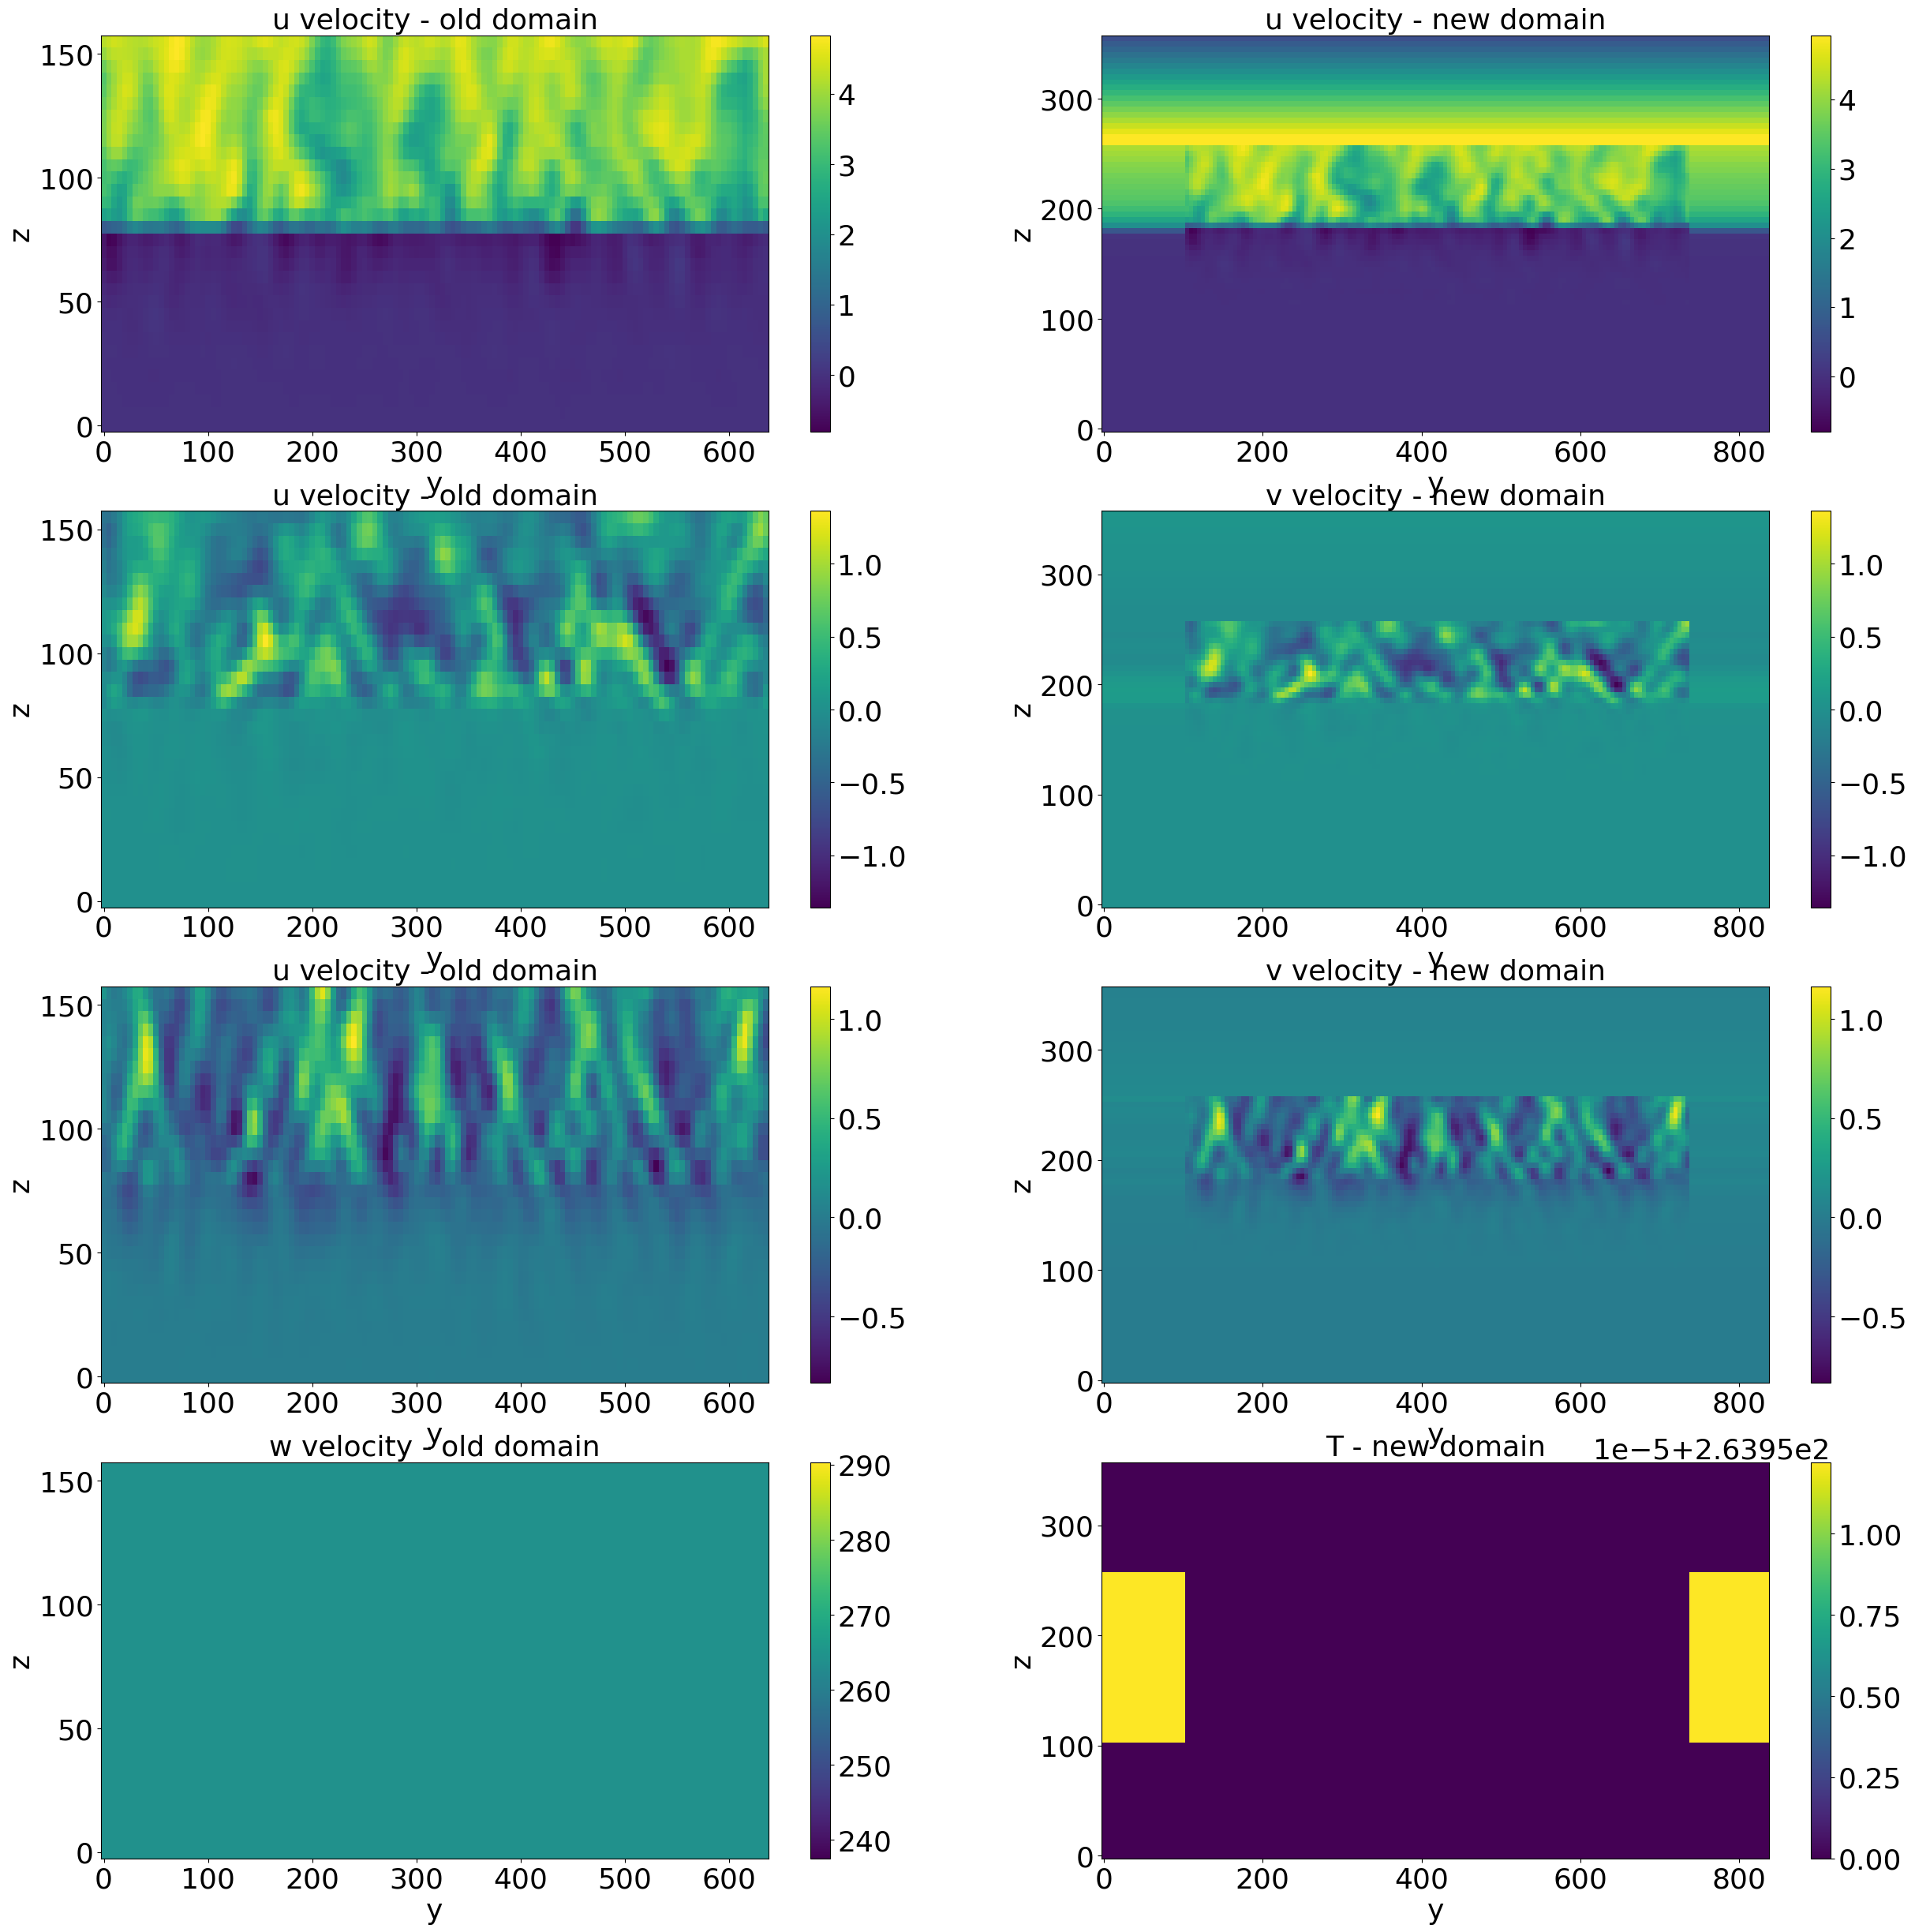

In [23]:
fig, axs = plt.subplots(nrows=4,ncols=2,figsize=(30,30))

# 1. u velocity:
yy = np.arange(ylo, yhi, dy)
zz = np.arange(zlo, zhi, dz)
YY, ZZ = np.meshgrid(yy, zz, indexing='ij')
uvel = axs[0,0].pcolormesh(YY, ZZ, x0_velocity_bc[-1,:,:])
axs[0,0].set_xlabel("y")
axs[0,0].set_ylabel("z")
axs[0,0].set_title("u velocity - old domain")
fig.colorbar(uvel, ax=axs[0,0])

yy_new = np.arange(ylo0, yhi0, dy)
zz_new = np.arange(zlo0, zhi0, dz)
YY_new, ZZ_new = np.meshgrid(yy_new, zz_new, indexing='ij')
uvel_new = axs[0,1].pcolormesh(YY_new, ZZ_new, velocity0_bc_new[-1,:,:,0])
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].set_title("u velocity - new domain")
fig.colorbar(uvel_new, ax=axs[0,1])

yy = np.arange(ylo, yhi, dy)
zz = np.arange(zlo, zhi, dz)
YY, ZZ = np.meshgrid(yy, zz, indexing='ij')
uvel = axs[1,0].pcolormesh(YY, ZZ, y0_velocity_bc[-1,:,:])
axs[1,0].set_xlabel("y")
axs[1,0].set_ylabel("z")
axs[1,0].set_title("u velocity - old domain")
fig.colorbar(uvel, ax=axs[1,0])

yy_new = np.arange(ylo0, yhi0, dy)
zz_new = np.arange(zlo0, zhi0, dz)
YY_new, ZZ_new = np.meshgrid(yy_new, zz_new, indexing='ij')
uvel_new = axs[1,1].pcolormesh(YY_new, ZZ_new, velocity0_bc_new[-1,:,:,1])
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].set_title("v velocity - new domain")
fig.colorbar(uvel_new, ax=axs[1,1])

yy = np.arange(ylo, yhi, dy)
zz = np.arange(zlo, zhi, dz)
YY, ZZ = np.meshgrid(yy, zz, indexing='ij')
uvel = axs[2,0].pcolormesh(YY, ZZ, z0_velocity_bc[-1,:,:])
axs[2,0].set_xlabel("y")
axs[2,0].set_ylabel("z")
axs[2,0].set_title("u velocity - old domain")
fig.colorbar(uvel, ax=axs[2,0])

yy_new = np.arange(ylo0, yhi0, dy)
zz_new = np.arange(zlo0, zhi0, dz)
YY_new, ZZ_new = np.meshgrid(yy_new, zz_new, indexing='ij')
uvel_new = axs[2,1].pcolormesh(YY_new, ZZ_new, velocity0_bc_new[-1,:,:,2])
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].set_title("v velocity - new domain")
fig.colorbar(uvel_new, ax=axs[2,1])

yy = np.arange(ylo, yhi, dy)
zz = np.arange(zlo, zhi, dz)
YY, ZZ = np.meshgrid(yy, zz, indexing='ij')
uvel = axs[3,0].pcolormesh(YY, ZZ, temperature0_bc[-1,:,:])
axs[3,0].set_xlabel("y")
axs[3,0].set_ylabel("z")
axs[3,0].set_title("w velocity - old domain")
fig.colorbar(uvel, ax=axs[3,0])

yy_new = np.arange(ylo0, yhi0, dy)
zz_new = np.arange(zlo0, zhi0, dz)
YY_new, ZZ_new = np.meshgrid(yy_new, zz_new, indexing='ij')
uvel_new = axs[3,1].pcolormesh(YY_new, ZZ_new, temperature0_bc_new[-1,:,:])
axs[3,1].set_xlabel("y")
axs[3,1].set_ylabel("z")
axs[3,1].set_title("T - new domain")
fig.colorbar(uvel_new, ax=axs[3,1])

In [24]:
print(ZZ)

print()
      
print(ZZ_new)

[[  0.   5.  10. ... 145. 150. 155.]
 [  0.   5.  10. ... 145. 150. 155.]
 [  0.   5.  10. ... 145. 150. 155.]
 ...
 [  0.   5.  10. ... 145. 150. 155.]
 [  0.   5.  10. ... 145. 150. 155.]
 [  0.   5.  10. ... 145. 150. 155.]]

[[  0.   5.  10. ... 345. 350. 355.]
 [  0.   5.  10. ... 345. 350. 355.]
 [  0.   5.  10. ... 345. 350. 355.]
 ...
 [  0.   5.  10. ... 345. 350. 355.]
 [  0.   5.  10. ... 345. 350. 355.]
 [  0.   5.  10. ... 345. 350. 355.]]


168 1344
72 8.0
4.0
10.0


In [25]:
############################# Output: #################################

In [26]:
print(time_bc[1]-time_bc[0])
print(time_bc[2]-time_bc[1])
print(np.average(np.diff(time_bc)))
final_time = time_bc[-1]-time_bc[0]
print(final_time)
final_time=59.6

0.1
0.1
0.1
60.0


In [27]:
print(Niter_lz-2)
dt= np.average(np.diff(time_bc))

#diff_time_bc = np.diff(time_bc)
#print(diff_time_bc)

#time_bc_avg = np.average(np.diff(time_bc))*10
#print(time_bc_avg)

#print(time_bc_avg*time_size)

times_in_seconds = np.arange(0.0,59.6,0.1)
print(times_in_seconds)
print(np.size(times_in_seconds))
#time_in_seconds = []
#for i in range(diff_time_bc): # in the y dir
#    time_in_seconds[i] = time_in_seconds[i] + .append(diff_time_bc

596
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 1

In [28]:
print(Ly0_new, Lz0_new)


print("new domain extent")
print(ylo0, yhi0, zlo0, zhi0)



840 360
new domain extent
0 840.0 0.0 360.0


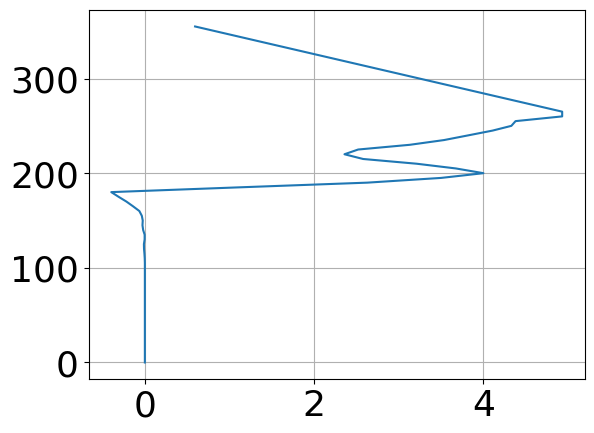

In [30]:
# plot of mean temperature
zz = np.arange(zlo0, zhi0, dz)
plt.figure()
plt.grid()
plt.plot(velocity0_bc_new[-1,80,:,0],zz)

In [ ]:
#zlo0 = -80 - delta_Lz/2
#zhi0 = 80 + delta_Lz/2

zlo0 = 0.
zhi0 = 360.


print(Ny0, Nz0)

print(time_bc.size,times_in_seconds.size,velocity0_bc_new.size)
#print(zlo0, zhi0)

In [ ]:
# outfile = Path(template_file.parent, synthetic_bcs.nc)
with Dataset(outfile, "w", format="NETCDF4") as rootgrp:
    ## ~~~~~~~~ Operate on the root group ~~~~~~~~
    # Add dimensions to the root group
    rootgrp.createDimension('sdim', 1)
    rootgrp.createDimension('pdim', 2)
    rootgrp.createDimension('vdim', 3)
    rootgrp.createDimension('nt', None)
    
    # Add groups
    grp_xlo = rootgrp.createGroup("/xlo")
    
    # Add variables    
    rootgrp.createVariable("time","f8",("nt",))
    rootgrp['time'][:] = times_in_seconds

    ## ~~~~~~~~ Operate on the xlo and ylo groups ~~~~~~~~
    # No need to add dimensions

    # Add variables
    grp_xlo.createVariable("normal","i4",)
    grp_xlo.createVariable("side","i4",)
    grp_xlo.createVariable("perpendicular","i4",("pdim",))
    
    grp_xlo['normal'][:] = 0
    grp_xlo['side'][:] = 0
    grp_xlo['perpendicular'][:] = [1, 2]

    ## ~~~~~~~~ Operate on the xlo/level_0 and ylo/level_0 groups ~~~~~~~~
    # Add groups
    grp_xlo_l0 = grp_xlo.createGroup('/level_0')

    # Add dimensions
    grp_xlo_l0.createDimension('nx', 1)
    grp_xlo_l0.createDimension('ny', Ny0)
    grp_xlo_l0.createDimension('nz', Nz0)

    # No need to add groups
    
    # Add variables
    grp_xlo_l0.createVariable("lengths","f8",("pdim",))
    grp_xlo_l0.createVariable("lo","f8",("pdim",))
    grp_xlo_l0.createVariable("hi","f8",("pdim",))
    grp_xlo_l0.createVariable("dx","f8",("pdim",))
    grp_xlo_l0.createVariable("velocity","f8",("nt", "ny", "nz", "vdim",))
    grp_xlo_l0.createVariable("temperature","f8",("nt", "ny", "nz",))
#    grp_xlo_l0.createVariable("vof","f8",("nt", "ny", "nz",))
    
    grp_xlo_l0['lengths'][:] = [Ly0_new, Lz0_new]
    grp_xlo_l0['lo'][:] = [ylo0, zlo0]
    grp_xlo_l0['hi'][:] = [yhi0, zhi0]
    grp_xlo_l0['dx'][:] = [dy, dz]
    grp_xlo_l0['velocity'][:] = velocity0_bc_new
    grp_xlo_l0['temperature'][:] = temperature0_bc_new
#    grp_xlo_l0['vof'][:] = vof_bc_new
    
    print("hello")
    print(1, Ny0, Nz0)
    print(grp_xlo_l0['lengths'][:])
    print(grp_xlo_l0['velocity'])
    print(grp_xlo_l0['lo'][:])
    print(grp_xlo_l0['hi'][:])
    print(grp_xlo_l0['dx'][:])

In [ ]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(20,20))
yy_new = np.arange(ylo0, yhi0, dy0)
zz_new = np.arange(zlo0, zhi0, dz0)
YY_new, ZZ_new = np.meshgrid(yy_new, zz_new, indexing='ij')
wvel_new = axs[0,0].pcolormesh(YY_new, ZZ_new, velocity0_bc_new[Niter_lz-2,:,:,0])
axs[0,0].set_xlabel("y")
axs[0,0].set_ylabel("z")
axs[0,0].set_title("w velocity - new domain")
fig.colorbar(wvel_new, ax=axs[0,0])

In [ ]:
with Dataset(outfile, "r") as rootgrp:
    print("rootgrp['xlo']['level_0']", rootgrp['xlo']['level_0'])
    print("rootgrp['xlo']['level_0'].dimensions", rootgrp['xlo']['level_0'].dimensions)
    print("rootgrp['xlo']['level_0'].variables", rootgrp['xlo']['level_0'].variables)
    print("rootgrp['xlo']['level_0']['lengths'][:]", rootgrp['xlo']['level_0']['lengths'][:])
    print("rootgrp['xlo']['level_0']['lo'][:]", rootgrp['xlo']['level_0']['lo'][:])
    print("rootgrp['xlo']['level_0']['hi'][:]", rootgrp['xlo']['level_0']['hi'][:])
    print("rootgrp['xlo']['level_0']['dx'][:]", rootgrp['xlo']['level_0']['dx'][:])
    print("rootgrp['xlo']['level_0']['velocity'][-5:,0,0,:]", rootgrp['xlo']['level_0']['velocity'][-5:,0,0,:])
    print("rootgrp['xlo']['level_0']['temperature'][-5:,0,0]", rootgrp['xlo']['level_0']['temperature'][-5:,0,0])
    print("rootgrp['xlo'].groups", rootgrp['xlo'].groups)

In [ ]:
outfile2 = '/scratch/sbidadi/ai4wind/windai/simulations/maine_sweep/wspd05_ai/amrwind_wspd_5_0_ai_inflow_bc.nc'
with Dataset(outfile2, "r") as rootgrp:
    print("rootgrp['xlo']['level_0']", rootgrp['xlo']['level_0'])
    print("rootgrp['xlo']['level_0'].dimensions", rootgrp['xlo']['level_0'].dimensions)
    print("rootgrp['xlo']['level_0'].variables", rootgrp['xlo']['level_0'].variables)
    print("rootgrp['xlo']['level_0']['lengths'][:]", rootgrp['xlo']['level_0']['lengths'][:])
    print("rootgrp['xlo']['level_0']['lo'][:]", rootgrp['xlo']['level_0']['lo'][:])
    print("rootgrp['xlo']['level_0']['hi'][:]", rootgrp['xlo']['level_0']['hi'][:])
    print("rootgrp['xlo']['level_0']['dx'][:]", rootgrp['xlo']['level_0']['dx'][:])
    print("rootgrp['xlo']['level_0']['velocity'][-5:,0,0,:]", rootgrp['xlo']['level_0']['velocity'][-5:,0,0,:])
    print("rootgrp['xlo']['level_0']['temperature'][-5:,0,0]", rootgrp['xlo']['level_0']['temperature'][-5:,0,0])
    print("rootgrp['xlo'].groups", rootgrp['xlo'].groups)